In [21]:
import csv
import pickle
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
def load_data_dir(path):
    data = None
    for filename in os.listdir(path):
        new = np.genfromtxt(os.path.join(path, filename), delimiter=',')
        if data is None:
            data = new
        else:
            data = np.concatenate((data, new))
    return np.split(data, (-1,), axis=1)

test_data, test_labels = load_data_dir('../brain-data/test')
validation_data, validation_labels = load_data_dir('../brain-data/validation')
train_data, train_labels = load_data_dir('../brain-data/train')

In [24]:
def create_model(path, *, criterion='gini', overwrite=False, n_estimators=50, max_depth=15, random_state=123456):
    if os.path.isfile(path) and not overwrite:
        print('loading model...')
        with open(path, 'rb') as f:
            rf = pickle.load(f)
        print(f'Model loaded! Original training time {rf.training_time:.2f}')
    else:
        resp = input('type "train" to confirm you want to train a new model: ')
        if resp != 'train':
            print('training aborted')
            return
        else:
            print('training...')
            rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                        max_depth=max_depth, random_state=random_state)
            now = time.time()
            rf.fit(train_data, train_labels.ravel().astype(int))
            rf.training_time = time.time() - now
            print(f'trained! Elapsed time {rf.training_time:.2f}')
            with open(path, 'wb') as f:
                pickle.dump(rf, f)
    return rf

In [26]:
gini = create_model('../models/random_forest_classifier_gini.pickle')
entropy = create_model('../models/random_forest_classifier_entropy.pickle')

loading model...
Model loaded! Original training time 1078.70
loading model...
Model loaded! Original training time 672.53


In [45]:
def measure_accuracy(model, test_data, test_labels):
    predicted = model.predict(test_data)
    accuracy = accuracy_score(test_labels, predicted)
    print(f'Mean accuracy score: {accuracy*100:.3f}%')
    
    target_names = ['background', 'foreground']
    cm = pd.DataFrame(confusion_matrix(test_labels, predicted), columns=target_names, index=target_names)
    cm = cm.apply(np.log10)
    cm = cm / cm.values.sum()
    ax = sns.heatmap(cm, annot=True)
    ax.set_title('Log-Normalized Accuracy')

Mean accuracy score: 99.767%


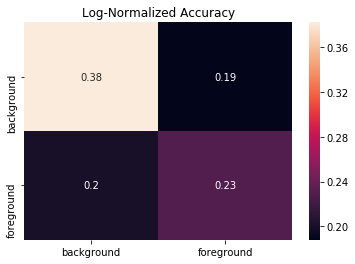

In [46]:
measure_accuracy(gini, test_data, test_labels)

Mean accuracy score: 99.768%


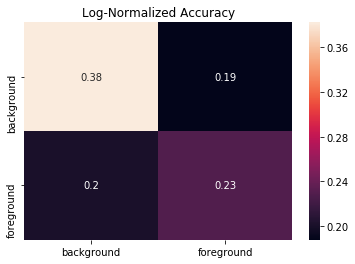

In [47]:
measure_accuracy(entropy, test_data, test_labels)